In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from utils.helpers import *
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
%load_ext autoreload
%autoreload 2

In [2]:
# Especifica las columnas que deseas cargar
columns_to_load = ['user_id', 'account_number', 'transaction_date', 'transaction_amount', 'transaction_type', 'fraction_flag']

# Lectura de los datos
data = pd.read_parquet(
    path='../../data/processed/data_processed.parquet',
    columns=columns_to_load
)

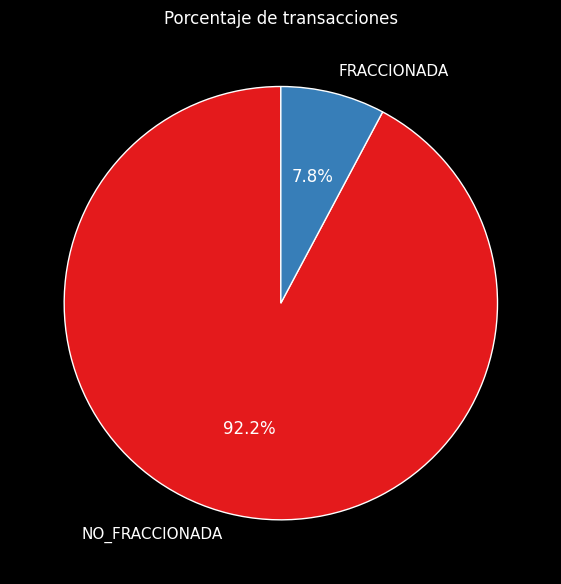

In [3]:
fraction_counts = data['fraction_flag'].value_counts()
fraction_labels = fraction_counts.index.tolist()

plt.figure(figsize=(8, 6))
plt.pie(
    fraction_counts, 
    labels=fraction_labels,
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette('Set1'),
    wedgeprops={'edgecolor': 'white'}
)
plt.title(f'Porcentaje de transacciones', fontsize=12)
plt.tight_layout()
plt.show()

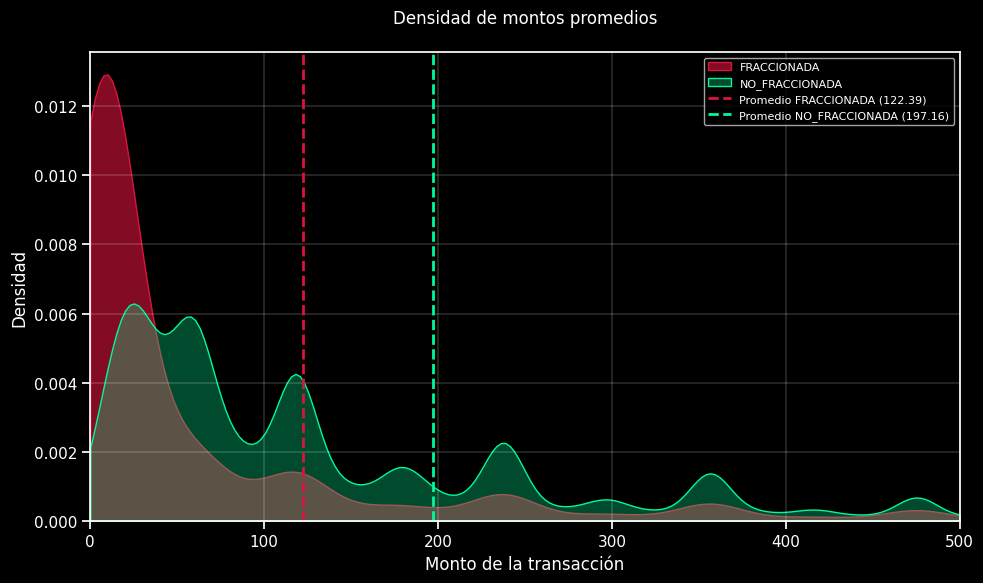

In [4]:
# Calcular montos promedios por fraction_flag
avg_amount_by_flag = data.groupby('fraction_flag')['transaction_amount'].mean()

# Crear gráfico de densidad para las categorías de fraction_flag
plt.figure(figsize=(10, 6))

# Ajustar límites del eje X
x_max = 500  # Limitar hasta 500 para valores relevantes

# Gráficos de densidad (KDE)
sns.kdeplot(
    data=data[data['fraction_flag'] == 'FRACCIONADA']['transaction_amount'], # type: ignore
    label='FRACCIONADA',
    fill=True,
    alpha=0.6,
    color='crimson',
    clip=(0, x_max)
)
sns.kdeplot(
    data=data[data['fraction_flag'] == 'NO_FRACCIONADA']['transaction_amount'], # type: ignore
    label='NO_FRACCIONADA',
    fill=True,
    alpha=0.3,
    color='mediumspringgreen',
    clip=(0, x_max)
)

# Superponer líneas de promedio
for category, avg in avg_amount_by_flag.items():
    color = 'crimson' if category == 'FRACCIONADA' else 'mediumspringgreen'
    plt.axvline(avg, color=color, linestyle='--', linewidth=2, label=f'Promedio {category} ({avg:.2f})')

# Personalización del gráfico
plt.title('Densidad de montos promedios\n')
plt.xlabel('Monto de la transacción')
plt.ylabel('Densidad')
plt.xlim(0, x_max)  # Limitar el eje X
plt.legend(fontsize=8)
plt.grid(color='white', linewidth=0.2)
plt.tight_layout()
plt.show()

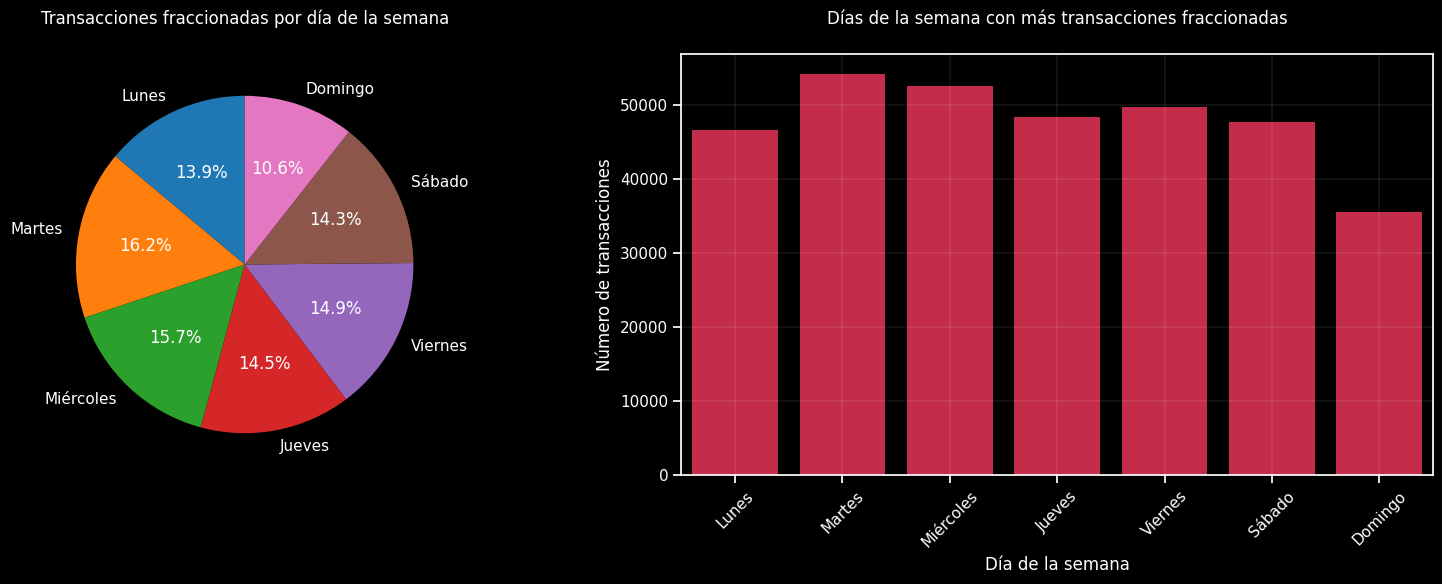

In [6]:
# Filtrar las transacciones fraccionadas (crear una copia explícita)
fraccionadas = data.loc[data['fraction_flag'] == 'FRACCIONADA'].copy()

# Agregar columna para el día de la semana usando loc
fraccionadas.loc[:, 'day_of_week'] = fraccionadas['transaction_date'].dt.day_name()

# Traducir los días de la semana al español
day_translation = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
fraccionadas['day_of_week'] = fraccionadas['day_of_week'].map(day_translation)

# Orden de los días de la semana
day_order = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Calcular la distribución por día de la semana para el gráfico de pastel
weekday_counts = fraccionadas['day_of_week'].value_counts()
weekday_counts = weekday_counts.reindex(day_order, fill_value=0)  # Manejar días ausentes con fill_value=0

# Crear los subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Dos gráficos, lado a lado

# Gráfico de pastel (Pie Chart)
axes[0].pie(
    weekday_counts,
    labels=weekday_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('tab10', len(weekday_counts))
)
axes[0].set_title('Transacciones fraccionadas por día de la semana\n', fontsize=12)

# Gráfico de barras (Countplot)
sns.countplot(
    data=fraccionadas,
    x='day_of_week',
    order=day_order,
    color='crimson',
    ax=axes[1]
)
axes[1].set_title('Días de la semana con más transacciones fraccionadas\n', fontsize=12)
axes[1].set_xlabel('Día de la semana')
axes[1].set_ylabel('Número de transacciones')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(color='white', linewidth=0.1)

# Ajustar diseño para evitar superposición
plt.tight_layout()
plt.show()


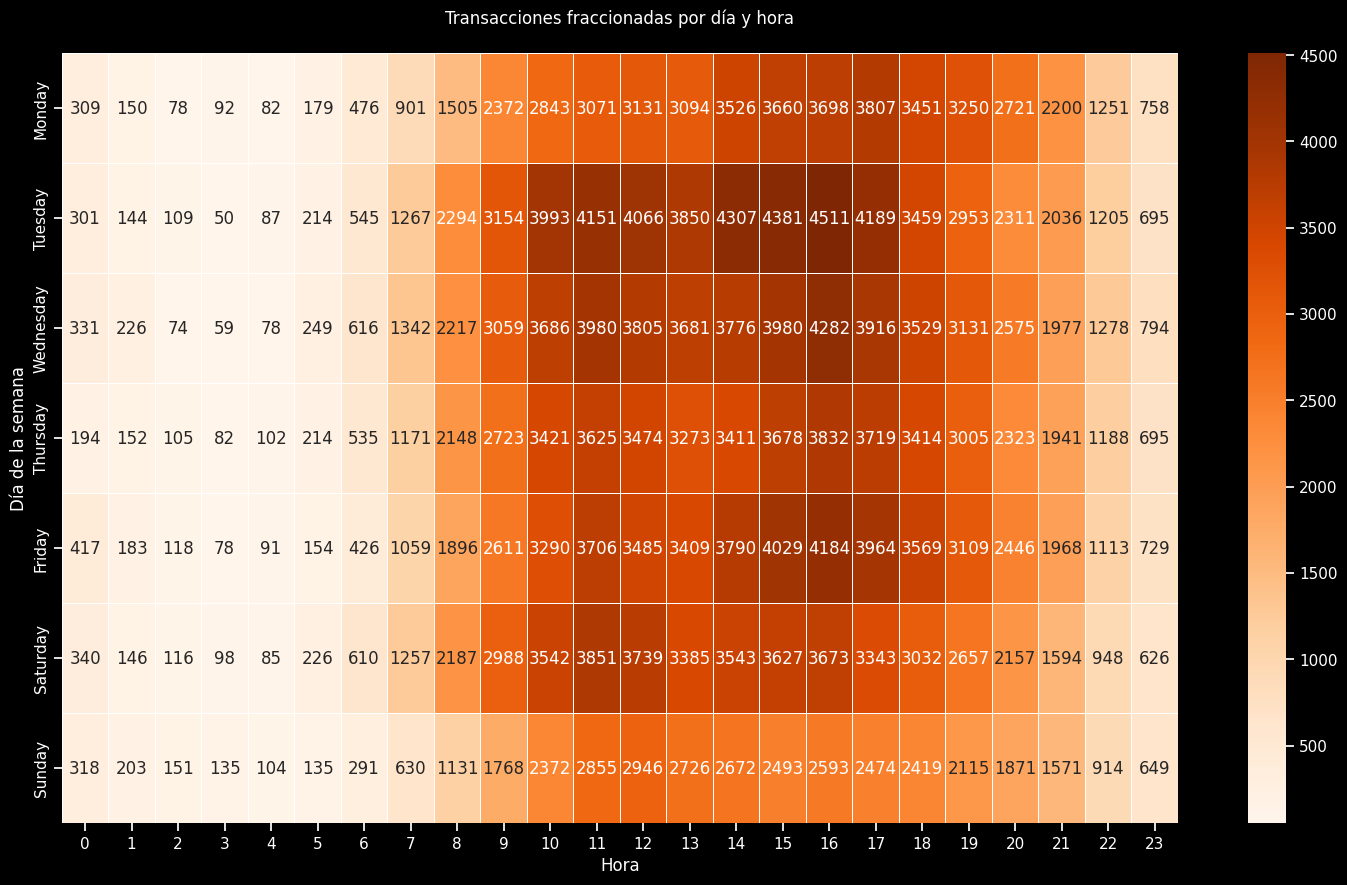

In [5]:
# Crear columnas adicionales para día de la semana y hora
fraccionadas = data[data['fraction_flag'] == 'FRACCIONADA']

# Crear columnas adicionales usando assign (evita modificar DataFrame directamente)
fraccionadas = fraccionadas.assign(
    day_of_week=fraccionadas['transaction_date'].dt.day_name(),
    hour=fraccionadas['transaction_date'].dt.hour
)

# Crear tabla cruzada (día de la semana vs hora)
heatmap_data = pd.pivot_table(
    fraccionadas,
    values='transaction_amount',  # Usa una columna para el conteo
    index='day_of_week',
    columns='hour',
    aggfunc='size',  # type: ignore
    fill_value=0
) # type: ignore

# Reordenar los días de la semana
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(day_order)

# Graficar el heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_data, cmap='Oranges', annot=True, fmt='d', linewidths=.5)
plt.title('Transacciones fraccionadas por día y hora\n', fontsize=12)
plt.xlabel('Hora')
plt.ylabel('Día de la semana')
plt.show()

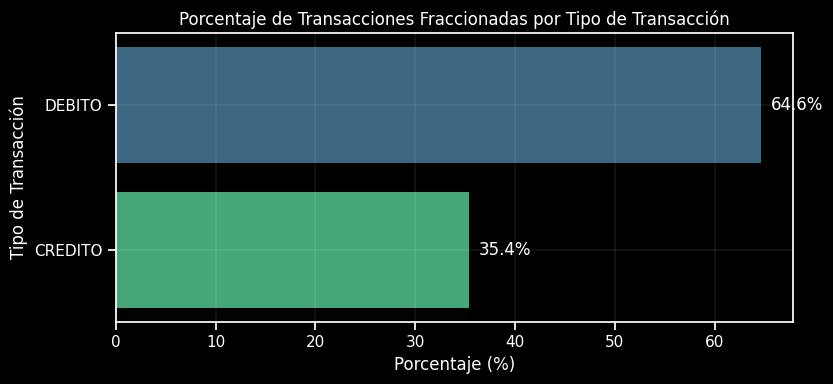

In [6]:
# Filtrar únicamente las transacciones fraccionadas
fraccionadas = data[data['fraction_flag'] == 'FRACCIONADA']
percentages_series = fraccionadas['transaction_type'].value_counts(normalize=True) * 100
percentages = percentages_series.to_frame(name='percentage').reset_index()
percentages.columns = ['transaction_type', 'percentage']  # Renombrar columnas

# Gráfico porcentual horizontal
plt.figure(figsize=(8.5, 4))
sns.barplot(
    data=percentages, 
    y='transaction_type', 
    x='percentage',
    hue='transaction_type',
    dodge=False,
    palette='viridis',
    legend=False
)
plt.title('Porcentaje de Transacciones Fraccionadas por Tipo de Transacción')
plt.xlabel('Porcentaje (%)')
plt.ylabel('Tipo de Transacción')

# Agregar etiquetas a las barras
for index, row in percentages.iterrows():
    plt.text(row['percentage'] + 1, index, f"{row['percentage']:.1f}%", va='center')

plt.grid(color='white', linewidth=0.1)
plt.tight_layout()
plt.show()

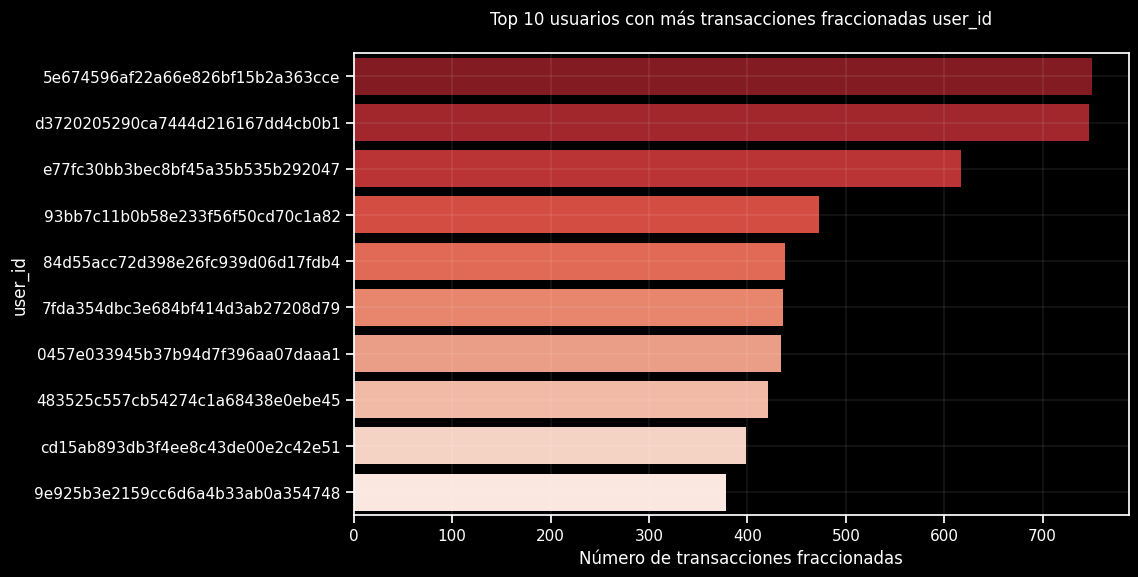

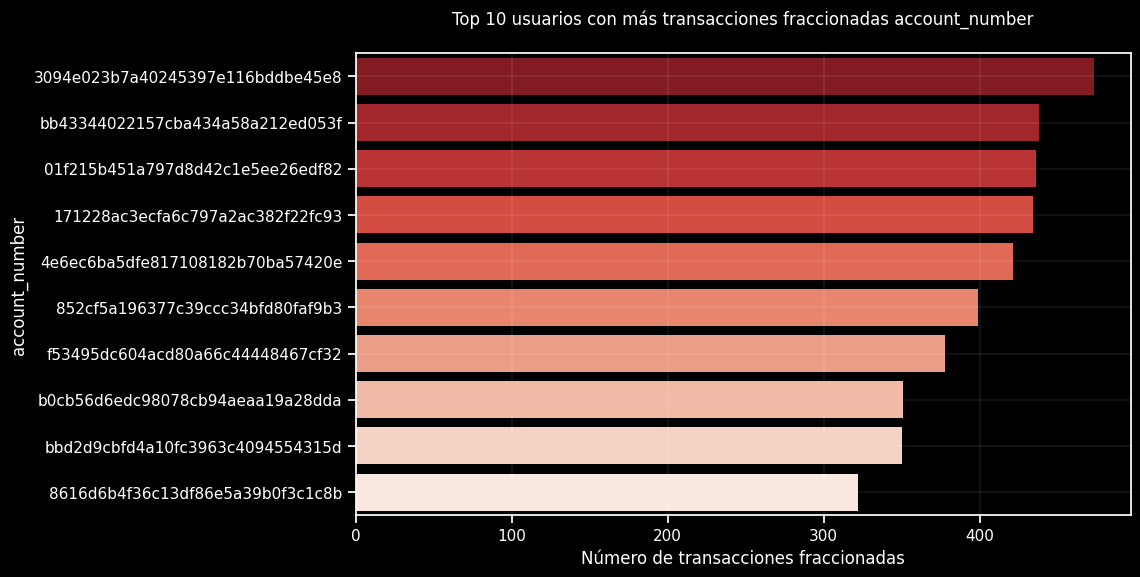

In [7]:
# Iterar por niveles de agrupación
levels = ['user_id', 'account_number']

for level in levels:
    # Agrupar por nivel y fraction_flag, luego calcular el conteo
    grouped_frac = (
        data.groupby([level, 'fraction_flag'])
            .size()
            .reset_index(name='count')
    )
    user_frac = (
        data.groupby([level, 'fraction_flag'])
            .size()
            .reset_index(name='count')
    )

    # Filtrar solo las fraccionadas
    top_frac_users = user_frac[user_frac['fraction_flag'] == 'FRACCIONADA']
    top_frac_users = top_frac_users.sort_values('count', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_frac_users, 
        x='count', 
        y=f'{level}', 
        palette='Reds_r',
        hue=f'{level}',
        dodge=False,
        legend=False
    )
    plt.title(f'Top 10 usuarios con más transacciones fraccionadas {level}\n')
    plt.xlabel('Número de transacciones fraccionadas')
    plt.ylabel(f'{level}')
    plt.grid(color='white', linewidth=0.1)
    plt.show()